In [1]:
import pandas as pd
import numpy as np
import datetime as dt

from tensorflow import keras
import tensorflow as tf
from keras.utils import timeseries_dataset_from_array

import plotly.express as px
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

### Importación de datos

Leemos el archivo y ordenamos por datetime

In [6]:
data_df = pd.read_csv('data_training/esios_data_modelo_dl.csv')
data_df['Datetime_hour'] = pd.to_datetime(data_df['Datetime_hour'])
data_df = data_df.sort_values(by=['Datetime_hour']).reset_index(drop=True)
data_df

,Datetime_hour,Gen.P48 Fotovoltaica,MD,IDA1,IDA2,Gen.P48 Eolica,Interconexiones P48,Demanda P48,Gen.P48 Total
0,2023-12-31 23:00:00,2.8,63.33,54.33,57.00,5520.1,525.9,21979.3,22640.6
1,2024-01-01 00:00:00,5.5,50.09,45.54,46.54,5528.0,229.7,21532.5,22561.3
2,2024-01-01 01:00:00,4.3,47.50,40.50,41.80,5155.8,-370.0,19869.1,21713.1
3,2024-01-01 02:00:00,2.7,43.50,38.95,34.53,4958.0,-58.1,18569.4,20250.0
4,2024-01-01 03:00:00,2.7,42.50,33.50,33.50,4915.2,-258.9,17979.8,20159.5
...,...,...,...,...,...,...,...,...,...
13867,2025-07-31 18:00:00,3933.6,107.99,119.91,122.38,9624.1,-2968.9,32146.3,35130.0
13868,2025-07-31 19:00:00,309.7,114.45,111.45,111.65,11052.2,-1356.7,32179.0,34616.8
13869,2025-07-31 20:00:00,0.3,110.27,109.22,110.22,12185.9,-2681.6,31008.0,35120.6
13870,2025-07-31 21:00:00,0.3,98.32,98.52,102.78,12407.5,-3586.2,28579.2,33451.4


### Visualización inicial

Visualizamos la forma de la función target para las últimas 2 semanas

In [3]:
px.line(data_df.iloc[-3*24*7:], x='Datetime_hour', y='MD')

### Preparación de datos

In [18]:
### PARAMETROS
fecha_inicio = '2025-01-01'

porc_train = 0.6
porc_val = 0.2
features = [col for col in data_df.columns if col not in ['Datetime_hour']]

input_steps = 24*7
output_steps = 24

batch_size = 32

In [ ]:
# Seleccionar valores
data_df = data_df.loc[data_df['Datetime_hour'] >= fecha_inicio]

# Convertir dataframe en array
data_array = data_df[features].values
data_array.shape


# Reescalar datos
train_steps = int(0.5 * len(data_array))
val_steps = int(0.25 * len(data_array))
test_steps = len(data_array) - train_steps - val_steps

scaler = StandardScaler()
scaler.fit(data_array)   # fit sólo con la porción de entrenamiento
data_scaled = scaler.transform(data_array) 


# Ventanas temporales
X, y = [], []

for i in range(len(data_scaled) - input_steps - output_steps):
    X.append(data_scaled[i:i+input_steps])
    y.append(data_scaled[i+input_steps:i+input_steps+output_steps, features.index('MD')])


X = np.array(X)
y = np.array(y)


# Dividir en Train, Val, Test y crear datasets
num_train_samples = int(porc_train*len(X))
num_val_samples = int(porc_val*len(X))
num_test_samples = len(X) - num_train_samples - num_val_samples

X_train = X[:num_train_samples]
y_train = y[:num_train_samples]

X_val = X[num_train_samples:num_train_samples + num_val_samples]
y_val = y[num_train_samples:num_train_samples + num_val_samples]

X_test = X[num_train_samples + num_val_samples:]
y_test = y[num_train_samples + num_val_samples:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")


# Crear datasets de tensorflow
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Train: (2937, 168, 8), Val: (979, 168, 8), Test: (979, 168, 8)
Train: (2937, 24), Val: (979, 24), Test: (979, 24)


### Calculo del error base

Tenemos que establecer un objetivo de precisión para nuestro modelo. Para ello, suponemos dos pronósticos iniciales:
1. El precio a la misma hora del día anterior
2. El precio a la misma hora y el mismo día de la semana anterior

Consideramos esta segunda posibilidad, debido a la gran diferencia que existe entre los precios en fin de semana y entre semana.

In [20]:
md_true = []
md_delay_day = []

# Calculamos los targets para el dataset sin escalar
for i in range(len(data_array) - input_steps - output_steps):
    md_true.append(data_array[i+input_steps:i+input_steps+output_steps, features.index('MD')])
    # Delay de 1 dia
    md_delay_day.append(data_array[i+input_steps-24:i+input_steps+output_steps-24, features.index('MD')])


md_true = np.array(md_true)
md_delay_day = np.array(md_delay_day)

print(f"MAE day-delay: {np.mean(np.abs(md_true - md_delay_day))}")

MAE day-delay: 19.292398025195777


### Modelo de Redes Neuronales Densas

In [44]:
inputs = keras.Input(shape=(input_steps, X_train.shape[-1]))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(32, activation="relu")(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")

Epoch 1/30


216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5906 - mae: 0.5802 - val_loss: 0.9051 - val_mae: 0.7526
Epoch 2/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3739 - mae: 0.4665 - val_loss: 0.8340 - val_mae: 0.7167
Epoch 3/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3353 - mae: 0.4377 - val_loss: 0.7915 - val_mae: 0.7000
Epoch 4/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3180 - mae: 0.4223 - val_loss: 0.8416 - val_mae: 0.7186
Epoch 5/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3205 - mae: 0.4238 - val_loss: 0.8008 - val_mae: 0.6958
Epoch 6/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3119 - mae: 0.4160 - val_loss: 0.7737 - val_mae: 0.6941
Epoch 7/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3016 - mae: 0.4085 - val_loss: 0.7675 - val_mae: 0.6906
Epoch 8/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2916 - mae: 0.3988 - val_loss: 0.7824 - val_mae: 0.6989
Epoch 9/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2920 

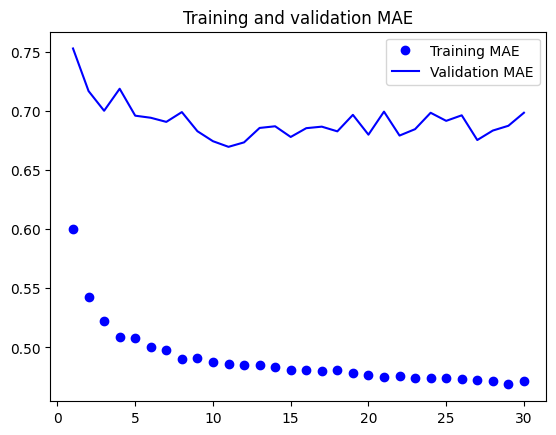

In [45]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Modelo LSTM

In [21]:
### PARAMETROS
dropout = 0.2
n_neurons = 64
r_drop = 0.25
patience = 15
lr = 0.0005
n_epochs = 100

In [22]:
inputs = keras.Input(shape=(input_steps, data_array.shape[-1]))
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=True)(inputs)
x = keras.layers.Dropout(dropout)(x)
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=False)(inputs)
x = keras.layers.Dropout(dropout)(x)
outputs = keras.layers.Dense(24)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
]

optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
history = model.fit(train_ds,
                    epochs=n_epochs,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.9023 - mae: 0.7867 - val_loss: 0.4868 - val_mae: 0.5565
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.5063 - mae: 0.5524 - val_loss: 0.4318 - val_mae: 0.5072
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.4457 - mae: 0.5157 - val_loss: 0.3924 - val_mae: 0.4776
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.4110 - mae: 0.4918 - val_loss: 0.3529 - val_mae: 0.4454
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.3866 - mae: 0.4772 - val_loss: 0.3262 - val_mae: 0.4183
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.3527 - mae: 0.4557 - val_loss: 0.3053 - val_mae: 0.4053
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.3324 - mae: 0.4422 - val_loss: 0.2834 - val_mae: 0.3924
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.3035 - mae: 0.4242 - val_loss: 0.2949 - val_mae: 0.3995
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - lo

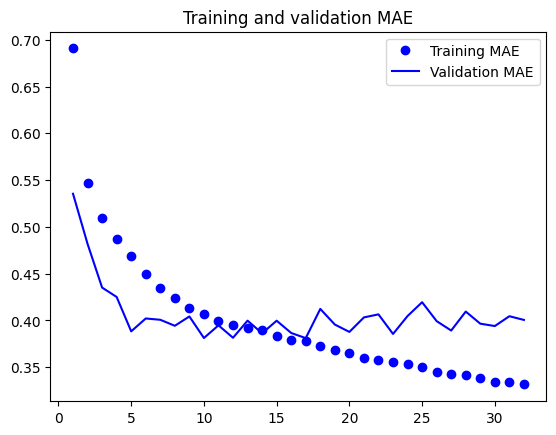

In [15]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Evaluación del test y visualización de resultados

In [16]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_ds)[1]:.2f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4926 - mae: 0.5584 
Test MAE: 0.52


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Métricas (escala original de MD):
MAE  = 27.7570
RMSE = 35.5995
MAPE = 10489080863.63%


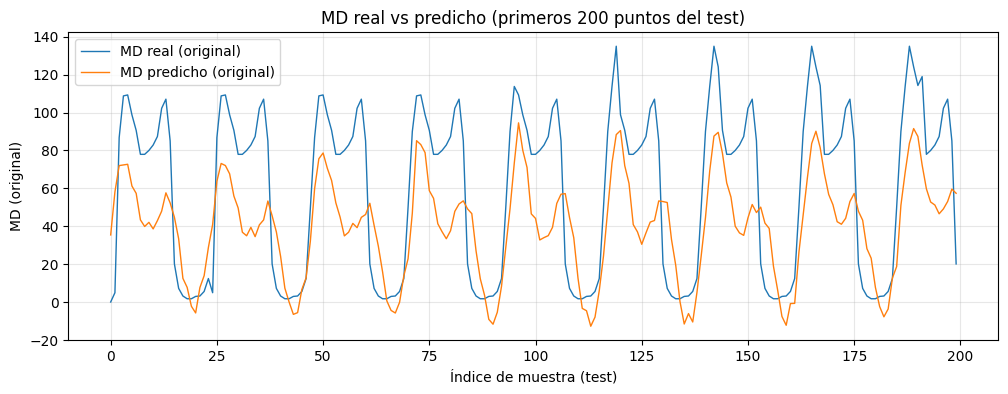

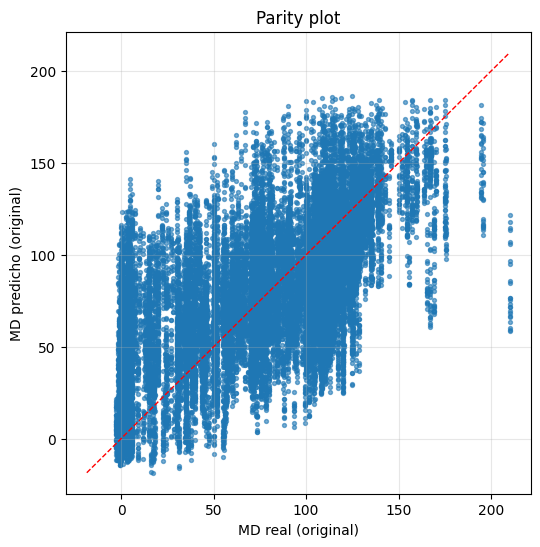

In [17]:
# ---------- 1) Recolectar y_true escalado desde test_ds ----------
# test_ds debe devolver (X_batch, y_batch)
y_true_batches = []
for _, yb in test_ds:
    # si yb es TensorFlow Tensor, convertir a numpy
    y_true_batches.append(yb.numpy() if hasattr(yb, "numpy") else yb)
y_true_scaled = np.concatenate(y_true_batches, axis=0)

# Normalizar dims
if y_true_scaled.ndim == 1:
    y_true_scaled = y_true_scaled.reshape(-1, 1)

# ---------- 2) Obtener predicciones escaladas ----------
y_pred_scaled = model.predict(test_ds)
if y_pred_scaled.ndim == 1:
    y_pred_scaled = y_pred_scaled.reshape(-1, 1)

# ---------- 3) Alinear shapes si es necesario ----------
# Si el modelo predice single-step (col=1) y los targets son multi-horizon (col>1),
# por defecto comparo la predicción con el primer horizonte (col 0).
if y_pred_scaled.shape != y_true_scaled.shape:
    if y_pred_scaled.shape[1] == 1 and y_true_scaled.shape[1] > 1:
        print("Aviso: modelo single-step vs targets multi-horizon -> compararé con el primer horizonte (col 0).")
        y_true_comp_scaled = y_true_scaled[:, 0].reshape(-1, 1)
        y_pred_comp_scaled = y_pred_scaled
    else:
        raise ValueError(f"Shapes incompatibles: y_pred {y_pred_scaled.shape} vs y_true {y_true_scaled.shape}")
else:
    y_true_comp_scaled = y_true_scaled
    y_pred_comp_scaled = y_pred_scaled

# ---------- 4) Invertir el escalado para MD usando el StandardScaler que definiste ----------
# Asumimos que 'scaler' existe y que 'features' contiene 'MD'
try:
    md_idx = features.index('MD')
except Exception:
    md_idx = 0
    print(f"Advertencia: no encontré 'MD' en 'features'. Uso md_idx={md_idx} (ajusta si es necesario).")

# Obtener media y escala desde el StandardScaler
try:
    mean_md = float(scaler.mean_[md_idx])
    scale_md = float(scaler.scale_[md_idx])
except Exception as e:
    raise RuntimeError("No he podido leer scaler.mean_ / scaler.scale_. Asegúrate de que 'scaler' exista y sea un StandardScaler fit() correctamente.") from e

def invert_md(arr_scaled):
    """Invertir escalado MD: orig = scaled * scale + mean
       arr_scaled: array (N, H) o (N,1) -> devuelve mismo shape
    """
    return arr_scaled * scale_md + mean_md

y_true_orig = invert_md(y_true_comp_scaled)
y_pred_orig = invert_md(y_pred_comp_scaled)

# ---------- 5) Métricas en escala original ----------
eps = 1e-8
def mape_np(a, b):
    return np.mean(np.abs((a - b) / (np.abs(a) + eps))) * 100

y_t = y_true_orig.ravel()
y_p = y_pred_orig.ravel()

mae_val = mean_absolute_error(y_t, y_p)
rmse_val = math.sqrt(mean_squared_error(y_t, y_p))
mape_val = mape_np(y_t, y_p)

print("Métricas (escala original de MD):")
print(f"MAE  = {mae_val:.4f}")
print(f"RMSE = {rmse_val:.4f}")
print(f"MAPE = {mape_val:.2f}%")

# ---------- 6) Visualizaciones ----------
# 6.1 Serie temporal comparada: primeros N puntos
N = 200
N = min(N, len(y_t))
plt.figure(figsize=(12,4))
plt.plot(np.arange(N), y_t[:N], label="MD real (original)", linewidth=1)
plt.plot(np.arange(N), y_p[:N], label="MD predicho (original)", linewidth=1)
plt.title(f"MD real vs predicho (primeros {N} puntos del test)")
plt.xlabel("Índice de muestra (test)")
plt.ylabel("MD (original)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 6.2 Parity plot
plt.figure(figsize=(6,6))
plt.scatter(y_t, y_p, s=8, alpha=0.6)
mn = min(y_t.min(), y_p.min())
mx = max(y_t.max(), y_p.max())
plt.plot([mn, mx], [mn, mx], "r--", linewidth=1)
plt.xlabel("MD real (original)")
plt.ylabel("MD predicho (original)")
plt.title("Parity plot")
plt.grid(alpha=0.3)
plt.show()
